In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Install Transformers Library

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertModel, BertTokenizer,BertForSequenceClassification,AutoModel,BertTokenizerFast,AutoTokenizer

# specify GPU
device = torch.device("cuda")

# Load Dataset (BANKING Dataset)

In [ ]:
df = pd.read_csv('/content/banking-train.csv',encoding='utf-8')
df.head()

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


In [ ]:
df.shape

(10003, 2)

In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

15    0.018694
28    0.018195
6     0.018095
75    0.017995
19    0.017695
        ...   
41    0.008198
18    0.006098
10    0.005898
72    0.004099
23    0.003499
Name: label, Length: 77, dtype: float64

In [ ]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df['label']= label_encoder.fit_transform(df['label'])

In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

15    0.018694
28    0.018195
6     0.018095
75    0.017995
19    0.017695
        ...   
41    0.008198
18    0.006098
10    0.005898
72    0.004099
23    0.003499
Name: label, Length: 77, dtype: float64

# Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.30, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import RoBERTA Model and Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('roberta-base')

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Tokenization

<Axes: >

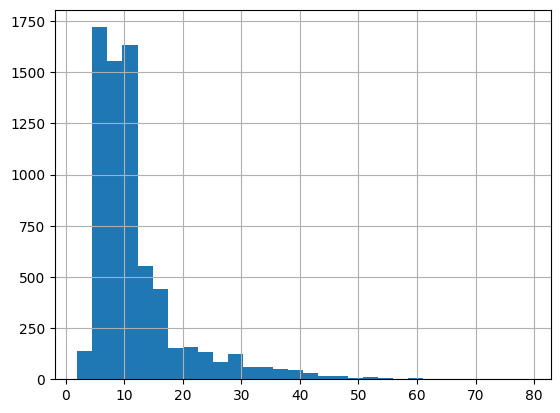

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 80 #For BANKING Dataset

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 128

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.lstm = nn.LSTM(768, 512)
      self.linear = nn.Linear(512*2, 256)
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 
      self.fc2 = nn.Linear(512,256)

      # dense layer 3 (Output Layer)
      self.fc3 = nn.Linear(256,7)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)

      x, _ = self.lstm(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # 2nd dense layer
      x = self.fc2(x)

      x = self.relu(x)

      x = self.dropout(x)
      
      # output layer
      self.fc3(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Loss Function and Epochs

In [ ]:
# loss function
cross_entropy  = nn.NLLLoss() 

# number of training epochs
epochs = 30

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
from datetime import time
from babel.dates import format_date, format_datetime, format_time
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')


# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 30
  Batch    50  of     55.

Evaluating...

Training Loss: 5.411
Validation Loss: 5.220

 Epoch 2 / 30
  Batch    50  of     55.

Evaluating...

Training Loss: 5.090
Validation Loss: 4.877

 Epoch 3 / 30
  Batch    50  of     55.

Evaluating...

Training Loss: 4.719
Validation Loss: 4.445

 Epoch 4 / 30
  Batch    50  of     55.

Evaluating...

Training Loss: 4.309
Validation Loss: 4.064

 Epoch 5 / 30
  Batch    50  of     55.

Evaluating...

Training Loss: 3.951
Validation Loss: 3.732

 Epoch 6 / 30
  Batch    50  of     55.

Evaluating...

Training Loss: 3.641
Validation Loss: 3.448

 Epoch 7 / 30
  Batch    50  of     55.

Evaluating...

Training Loss: 3.344
Validation Loss: 3.177

 Epoch 8 / 30
  Batch    50  of     55.

Evaluating...

Training Loss: 3.079
Validation Loss: 2.940

 Epoch 9 / 30
  Batch    50  of     55.

Evaluating...

Training Loss: 2.863
Validation Loss: 2.730

 Epoch 10 / 30
  Batch    50  of     55.

Evaluating...

Training Loss: 2.632
Validation L

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds,digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        24
           1     1.0000    0.9375    0.9677        16
           2     1.0000    0.9474    0.9730        19
           3     0.9286    1.0000    0.9630        13
           4     1.0000    0.9474    0.9730        19
           5     0.8077    0.8077    0.8077        26
           6     0.8621    0.9259    0.8929        27
           7     0.0000    0.0000    0.0000        24
           8     0.9600    1.0000    0.9796        24
           9     1.0000    0.9500    0.9744        20
          10     0.8750    0.7778    0.8235         9
          11     0.8333    0.8696    0.8511        23
          12     0.8125    0.7647    0.7879        17
          13     0.8750    1.0000    0.9333        21
          14     0.8750    0.8235    0.8485        17
          15     0.9630    0.9286    0.9455        28
          16     0.7812    1.0000    0.8772        25
          17     0.8889    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.crosstab(test_y, preds)

col_0,0,1,2,3,4,5,6
row_0,,,,,,,
0,271,0,0,2,0,0,0
1,0,282,0,0,0,0,0
2,0,1,284,0,0,0,0
3,1,0,0,284,0,2,0
4,0,0,0,0,281,0,0
5,0,0,2,4,0,268,3
6,0,0,0,0,0,9,269


# Get Predictions for Test Data

In [ ]:
df1 = pd.read_csv('/content/banking-test.csv',encoding='utf-8')
df1.head()

,text,label
0,How do I locate my card?,11
1,"I still have not received my new card, I order...",11
2,I ordered a card but it has not arrived. Help ...,11
3,Is there a way to know when my card will arrive?,11
4,My card has not arrived yet.,11


In [ ]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df1['label']= label_encoder.fit_transform(df1['label'])

In [ ]:
test_text=df1['text']
test_labels=df1['label']

In [ ]:
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds,digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9750    0.9873        40
           1     1.0000    1.0000    1.0000        40
           2     1.0000    1.0000    1.0000        40
           3     0.9756    1.0000    0.9877        40
           4     0.9487    0.9250    0.9367        40
           5     0.8158    0.7750    0.7949        40
           6     0.9722    0.8750    0.9211        40
           7     0.0000    0.0000    0.0000        40
           8     1.0000    0.9250    0.9610        40
           9     1.0000    1.0000    1.0000        40
          10     0.9024    0.9250    0.9136        40
          11     0.9024    0.9250    0.9136        40
          12     0.9231    0.9000    0.9114        40
          13     0.9524    1.0000    0.9756        40
          14     0.9070    0.9750    0.9398        40
          15     0.9487    0.9250    0.9367        40
          16     0.8298    0.9750    0.8966        40
          17     0.9070    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.crosstab(test_y, preds)

col_0,0,1,2,3,4,5,6,8,9,10,...,67,68,69,70,71,72,73,74,75,76
row_0,,,,,,,,,,,,,,,,,,,,,
0,39,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,37,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,38,0,0,0,0
73,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,37,0,0,0
74,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,38,0,0
